In [50]:
"""
This file contains the code to run the baseline experiments.

More specifically, we are investigating the performance of basic models on the CIFAR-10 and CIFAR-10H datasets. The tasks for these datasets are multi-class classification.

The basic models include:
    * ResNet-50
    * VGG-16
    * Logistic Regression
    * Random Forest
    * XGBoost
"""

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from typing import Tuple

# Loading Data

In [3]:
# Load CIFAR-10 dataset and return train, validation, and test DataLoaders
def load_cifar10() -> Tuple[Dataset, Dataset, Dataset]:
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32),
        ]
    )
    full_dataset = datasets.CIFAR10(root="../data/cifar-10", train=True, download=True, transform=transform)
    # we use the test dataset for training, similar to the CIFAR-10H experiment
    train_dataset = datasets.CIFAR10(root="../data/cifar-10", train=False, download=True, transform=transform)

    # This dataset will be used for testing and validation.
    #   30% of the data will be used for validation, and 70% for testing.
    test_size = int(0.7 * len(full_dataset))
    val_size = len(full_dataset) - test_size
    test_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [test_size, val_size], generator=torch.Generator().manual_seed(229)
    )

    return train_dataset, test_dataset, val_dataset

In [31]:
# Load CIFAR-10H dataset and return a Dataset
def load_cifar10h() -> Dataset:
    cifar10h_probs_path = "../data/cifar-10h/cifar10h-probs.npy"
    if not os.path.exists(cifar10h_probs_path):
        raise FileNotFoundError(
            f"Soft labels not found at {cifar10h_probs_path}. Please ensure the CIFAR-10H data is downloaded."
        )

    cifar10h_probs = np.load(cifar10h_probs_path).astype(np.float32)
    cifar10_test = datasets.CIFAR10(
        root="../data/cifar-10", train=False, download=True, transform=transforms.ToTensor()
    )

    class CIFAR10H(Dataset):
        def __init__(self, cifar10_dataset: Dataset, soft_labels: np.ndarray):
            self.cifar10_dataset = cifar10_dataset
            self.soft_labels = soft_labels

        def __len__(self) -> int:
            return len(self.cifar10_dataset)

        def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
            image, _ = self.cifar10_dataset[idx]
            soft_label = torch.from_numpy(self.soft_labels[idx])
            return image.float(), soft_label

    cifar10h_dataset = CIFAR10H(cifar10_test, cifar10h_probs)
    return cifar10h_dataset

In [32]:
cifar10h_dataset = load_cifar10h()
cifar10h_loader = DataLoader(cifar10h_dataset, batch_size=128, shuffle=True)
print(f"CIFAR-10H dataset loaded with {len(cifar10h_dataset)} samples")

cifar10_train_dataset, cifar10_test_dataset, cifar10_val_dataset = load_cifar10() 
cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=128, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=128, shuffle=False)
cifar10_val_loader = DataLoader(cifar10_val_dataset, batch_size=128, shuffle=False)
print(
    f"CIFAR-10 dataset loaded with {len(cifar10_train_dataset)} training, {len(cifar10_test_dataset)} test, and {len(cifar10_val_dataset)} validation samples"
)
class_names = cifar10_train_dataset.classes

Files already downloaded and verified
CIFAR-10H dataset loaded with 10000 samples
Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset loaded with 10000 training, 35000 test, and 15000 validation samples


## Visualizing embeddings from Neural Networks

In [ ]:
# Load a pre-trained ResNet model and modify it to output embeddings
resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove the last classification layer
resnet.eval()

#Extract embeddings
def get_embeddings(loader, model):
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, lbls in loader:
            emb = model(images).squeeze()  # Squeeze to remove extra dimensions
            embeddings.append(emb)
            labels.extend(lbls.numpy())
    embeddings = torch.cat(embeddings).numpy()
    return embeddings, np.array(labels)

cifar10_embeddings, cifar10_labels = get_embeddings(cifar10_train_loader, resnet)
cifar10h_embeddings, cifar10h_labels = get_embeddings(cifar10h_loader, resnet)
cifar10h_labels_best = np.argmax(cifar10h_labels, axis=1)


In [38]:
cifar10h_labels

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06      , 0.        , ..., 0.        , 0.        ,
        0.94      ],
       [0.97959185, 0.        , 0.        , ..., 0.        , 0.02040816,
        0.        ],
       ...,
       [0.9807692 , 0.01923077, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02      , ..., 0.08      , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]], dtype=float32)

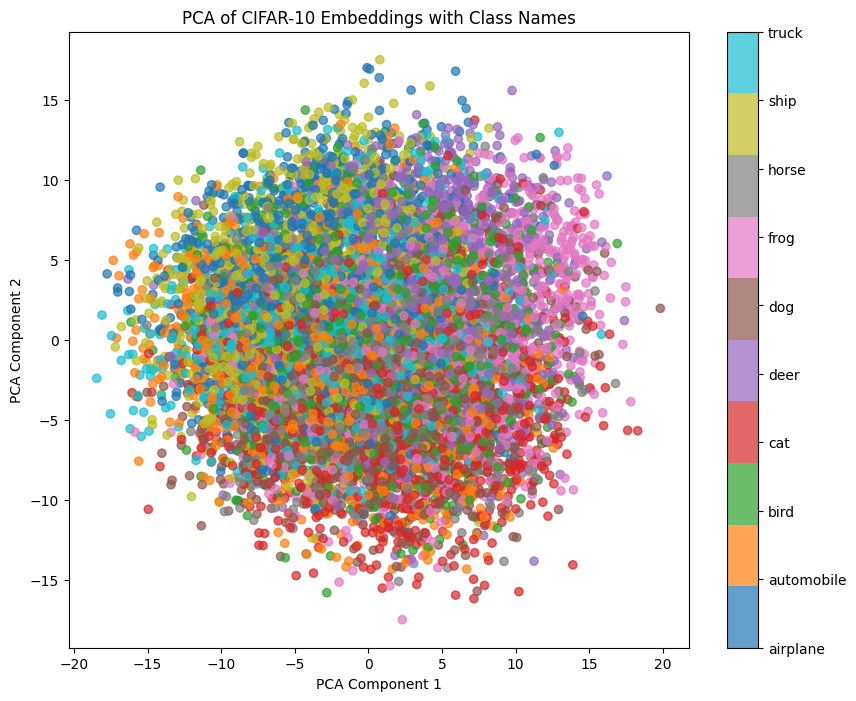

In [49]:
def plot_pca(embeddings, labels, title):
    #  Perform PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    # Plot PCA
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    cbar = plt.colorbar(scatter, ticks=range(10))
    cbar.ax.set_yticklabels(class_names)  # Set the class names as color bar labels
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"PCA of {title} Embeddings with Class Names")
    plt.show()

plot_pca(cifar10_embeddings, cifar10_labels, 'CIFAR-10')

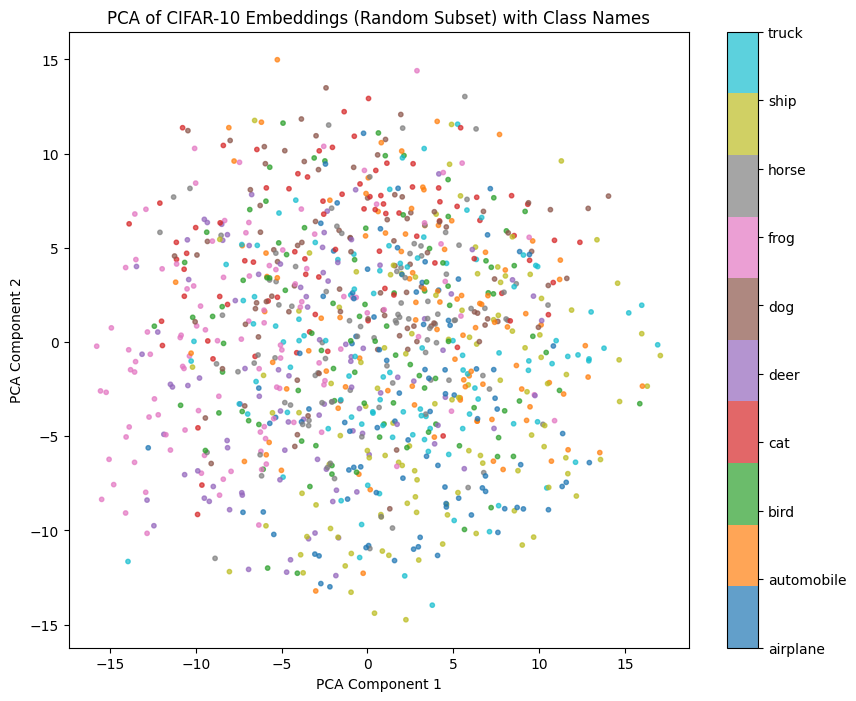

In [55]:
def plot_pca(embeddings, labels, title, subset_size=500):
    # Randomly select indices for the subset
    indices = np.random.choice(embeddings.shape[0], subset_size, replace=False)
    subset_embeddings = embeddings[indices]
    subset_labels = labels[indices]

    # Perform PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(subset_embeddings)

    # Plot PCA
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=subset_labels, cmap='tab10', alpha=0.7, s=10)
    cbar = plt.colorbar(scatter, ticks=range(10))
    cbar.ax.set_yticklabels(class_names)  # Set the class names as color bar labels
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"PCA of {title} Embeddings (Random Subset) with Class Names")
    plt.show()

# Example usage with a random subset of 500 points
plot_pca(cifar10_embeddings, cifar10_labels, 'CIFAR-10', subset_size=1000)

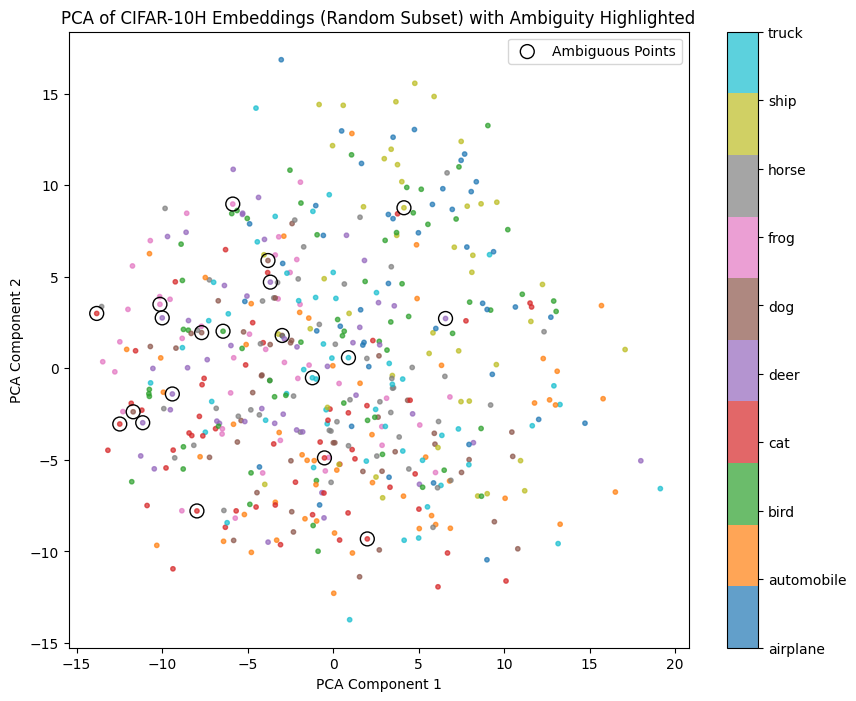

In [54]:
def plot_pca_with_ambiguity(embeddings, labels, title, class_names, subset_size=500, entropy_threshold=2.0):
    # Randomly select indices for the subset
    indices = np.random.choice(embeddings.shape[0], subset_size, replace=False)
    subset_embeddings = embeddings[indices]
    subset_labels = labels[indices]

    # Calculate entropy for each label distribution
    entropies = np.apply_along_axis(entropy, 1, subset_labels)

    # Perform PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(subset_embeddings)

    # Plot PCA
    plt.figure(figsize=(10, 8))
    
    # Plot points with color based on the predicted class (the maximum of the label distribution)
    predicted_classes = np.argmax(subset_labels, axis=1)
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=predicted_classes, cmap='tab10', alpha=0.7, s=10)
    
    # Highlight ambiguous points by circling them
    ambiguous_points = entropies > entropy_threshold
    plt.scatter(embeddings_2d[ambiguous_points, 0], embeddings_2d[ambiguous_points, 1], 
                facecolors='none', edgecolors='black', s=100, label='Ambiguous Points')
    
    # Colorbar for the scatter plot
    cbar = plt.colorbar(scatter, ticks=range(10))
    cbar.ax.set_yticklabels(class_names)  # Set the class names as color bar labels
    
    # Labels and title
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"PCA of {title} Embeddings (Random Subset) with Ambiguity Highlighted")
    
    # Show plot
    plt.legend(loc='upper right')
    plt.show()

# Example usage with a random subset of 500 points
# 'cifar10h_labels' should be your CIFAR-10H label distributions
plot_pca_with_ambiguity(cifar10h_embeddings, cifar10h_labels, 'CIFAR-10H', class_names, subset_size=500, entropy_threshold=0.7)

## Visualize tSNE for dimensionality reduction

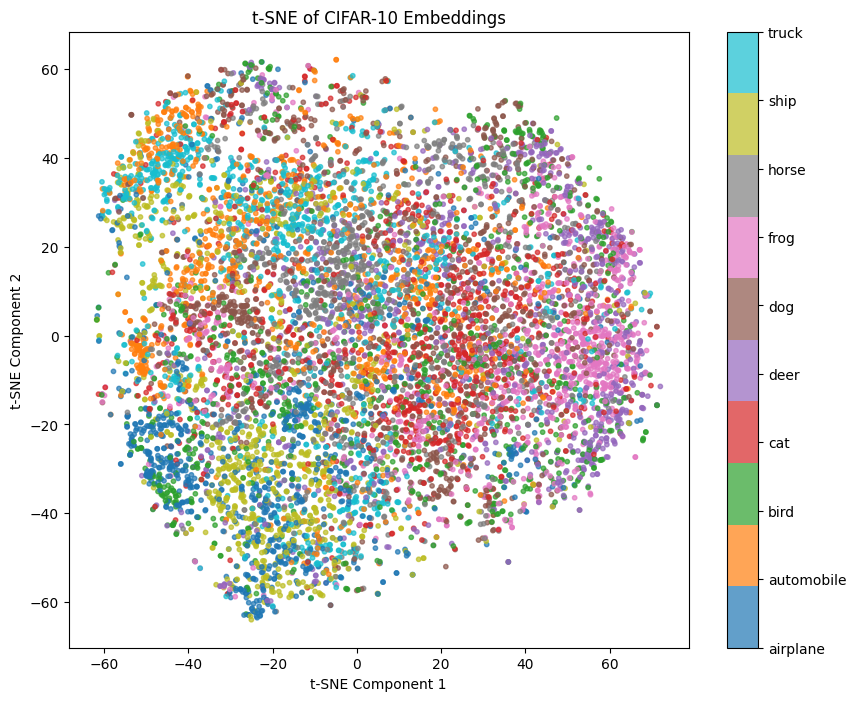

In [56]:
def plot_tsne(embeddings, labels, title):
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=229, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot t-SNE embeddings
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
    cbar = plt.colorbar(scatter, ticks=range(10))
    cbar.ax.set_yticklabels(class_names)  # Set class names in color bar
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(f"t-SNE of {title} Embeddings")
    plt.show()

plot_tsne(cifar10_embeddings, cifar10_labels, 'CIFAR-10')

## Visualizing Average image per class

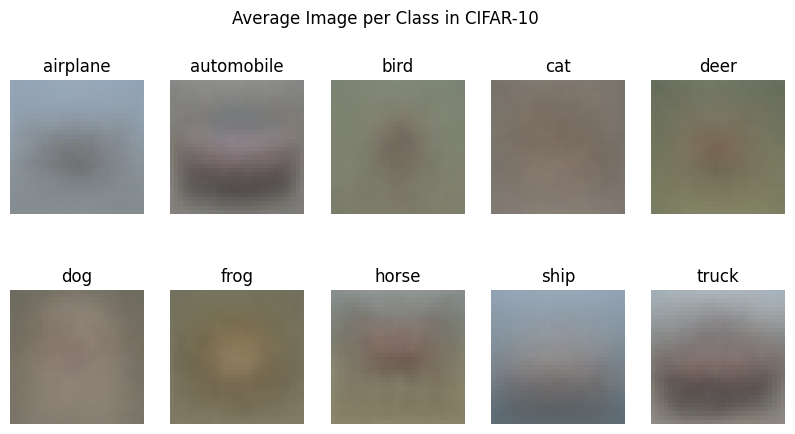

In [ ]:
def plot_avg_images(train_loader, title):
    # Compute the average image per class
    class_images = {i: [] for i in range(10)}  # Dictionary to hold images by class

    for images, labels in cifar10_train_loader:
        for img, label in zip(images, labels):
            class_images[label.item()].append(img)

    # Calculate the mean image for each class
    mean_images = {cls: torch.stack(images).mean(dim=0) for cls, images in class_images.items()}

    # Plot the average images
    plt.figure(figsize=(10, 5))
    for i, (cls, mean_img) in enumerate(mean_images.items()):
        mean_img = mean_img.permute(1, 2, 0).numpy()  # Convert to HxWxC format for plotting
        plt.subplot(2, 5, i + 1)
        plt.imshow(mean_img)
        plt.title(class_names[cls])
        plt.axis("off")

    plt.suptitle(f"Average Image per Class in {title}")
    plt.show()
plot_avg_images(cifar10_train_loader, 'CIFAR-10')
# plot_avg_images(cifar10h_train_loader, 'CIFAR-10H')